# Feature Engineering report -- 社説記事分類
計画情報システム特論の課題として、複数の新聞社の「社説」記事を収集し、特徴量エンジニアリングを利用して社説記事の分類実験を行いました。　　
以下は目次です。

0. データ収集
1. 分類のための特徴量の決定
2. 特徴量を用いた社説記事の分類実験
3. ソースコードとしての工夫点
4. 参考文献
5. 付録：ソースコード

## 0 データ収集
データソースとして、新聞社3社「毎日新聞」、「朝日新聞」と「読売新聞」の「社説」記事をウェブスクレイピングによって収集しました。

### 0.1 朝日新聞

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

N = 100
df = pd.DataFrame()
# URL of the webpage to scrape
url = 'https://www.asahi.com/articles/DA3S15675695.html?iref=pc_rensai_article_long_16_article_prev'

for i in range(N):
    # Send a GET request to the URL
    response = requests.get(url)
    print(i+1,'total scraped;', 'current url: ',url)
    # Create a BeautifulSoup object with the response content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the specific elements you want to scrape using appropriate selectors
    t = soup.select('#main > div.y_Qv3 > h1')[0].string #（社説）スマホ新規制　競争と安全の両立を
    close_paren_index = t.find('）')
    title = t[close_paren_index + 1:] # スマホ新規制　競争と安全の両立を

    date = soup.select('#main > div.y_Qv3 > div > span > time')[0].attrs['datetime'] # Complete ISO-8601 date

    ct = soup.find('div', class_='nfyQp')
    # Exclude the unwanted content (description for picture)
    for figure in ct.find_all('figure'):
        figure.decompose()

    # Exclude the unwanted 'div' with class 'notPrint'. Get rid of [PR] at the beginning of content
    unwanted_div = ct.find('div', class_='notPrint gXncj')
    if unwanted_div:
        unwanted_div.decompose()
    content = ct.get_text(strip=True)
    # foundForDesciption = soup.find('meta', attrs={'name': 'description'})
    # description = unicodedata.normalize('NFKC', foundForDesciption.get("content"))

    previous_url = soup.select('#main > div.notPrint.JTQCd > ul > li:nth-child(1) > div > a')[0].attrs['href']
    df = df.append({'Title': title, 'Date': date, 'Content': content}, ignore_index=True)
    url = previous_url

df.to_csv('./data/asahi100.csv', index=False)
# print(df)

### 0.2 毎日新聞

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

N = 100
df = pd.DataFrame()
url = 'https://mainichi.jp/articles/20230708/ddm/005/070/122000c'

for i in range(N):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    print(i+1,'total scraped;', 'current url: ',url)

    html_string = soup.select('#articledetail-title > div:nth-child(4) > span.articletag-date.is-articledetail')[0].string
    pattern = r'\d{4}/\d{1,2}/\d{1,2}'
    match = re.search(pattern, html_string)
    date = match.group()

    t = soup.select('#articledetail-title > h1')[0].string
    title = t.replace('\u3000', ' ')

    previous_url = 'https:' + soup.find('a', class_='articlenav-prev').attrs['href']
    url = previous_url

    ct = soup.find('div', class_='articledetail')
    unwanted_div = ct.find('div', class_='articletool')
    unwanted_div.decompose()
    unwanted_div = ct.find('div', class_='articledetail-subcontents')
    unwanted_div.decompose()
    content = ct.get_text(strip=True)

    df = df.append({'Title': title, 'Date': date, 'Content': content}, ignore_index=True)

df.to_csv('./data/mainichi100.csv', index=False)
# print(df)

### 0.3 読売新聞
* there is a 'さらに読み込む' button that I don't know how to handle. The solution is to manually click the button several time until enough(100) articles are available.

In [4]:
# モジュールの中のクラスを指定してimport
from selenium import webdriver
from selenium.webdriver.chrome import service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import time

# Chromeを起動する
driver_path = r'C:\Users\kinue\Documents\2023\feature_engi_report\chromedriver_win32\chromedriver.exe'
chrome_service = service.Service(executable_path=driver_path)
driver = webdriver.Chrome(service=chrome_service)
# chromedriverが見つかるまでの待ち時間
driver.implicitly_wait(2)

init_url="https://www.yomiuri.co.jp/editorial/"
driver.get(init_url)
print(init_url, ":start page")
time.sleep(2)

https://www.yomiuri.co.jp/editorial/ :start page


In [11]:
N = 100
urls = []
elements = driver.find_elements(By.CLASS_NAME, 'p-list-item')
for element in elements:
    try:
        url = element.find_element(By.CSS_SELECTOR,'a').get_attribute('href')
        cl = element.find_element(By.CSS_SELECTOR,'div').get_attribute('class')
        if  (cl == 'p-list-item__inner' or cl == 'p-list-item__innerfirst') and (len(urls) < N):
            urls.append(url)
    except NoSuchElementException:
        # Handle the case when an element doesn't have an <a> tag
        pass
# print(urls)
# print(len(urls))
# driver.quit()

['https://www.yomiuri.co.jp/editorial/20230708-OYT1T50208/', 'https://www.yomiuri.co.jp/editorial/20230708-OYT1T50211/', 'https://www.yomiuri.co.jp/editorial/20230707-OYT1T50249/', 'https://www.yomiuri.co.jp/editorial/20230707-OYT1T50246/', 'https://www.yomiuri.co.jp/editorial/20230706-OYT1T50325/', 'https://www.yomiuri.co.jp/editorial/20230706-OYT1T50322/', 'https://www.yomiuri.co.jp/editorial/20230705-OYT1T50244/', 'https://www.yomiuri.co.jp/editorial/20230705-OYT1T50241/', 'https://www.yomiuri.co.jp/editorial/20230704-OYT1T50239/', 'https://www.yomiuri.co.jp/editorial/20230704-OYT1T50236/', 'https://www.yomiuri.co.jp/editorial/20230703-OYT1T50226/', 'https://www.yomiuri.co.jp/editorial/20230703-OYT1T50223/', 'https://www.yomiuri.co.jp/editorial/20230702-OYT1T50218/', 'https://www.yomiuri.co.jp/editorial/20230702-OYT1T50215/', 'https://www.yomiuri.co.jp/editorial/20230701-OYT1T50247/', 'https://www.yomiuri.co.jp/editorial/20230701-OYT1T50244/', 'https://www.yomiuri.co.jp/editorial/20

In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

df = pd.DataFrame()

for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    t= soup.select('body > div.layout-contents > div.layout-contents__main > div.uni-scrap > article > div.article-header > h1')[0].string
    title = re.sub(r'\s+|[\u3000]', '', t)

    dt = soup.select('body > div.layout-contents > div.layout-contents__main > div.uni-scrap > article > div.article-header > div > div.c-article-header-date > time')[0].string
    date = dt.split(' ')[0]

    ct = soup.find('div', class_='p-main-contents').get_text(strip=True)
    content = ct.split('あわせて読みたい')[0]

    df = df.append({'Title': title, 'Date': date, 'Content': content}, ignore_index=True)
# print(df)
df.to_csv('./data/yomiuri100.csv', index=False)

                                              Content        Date  \
0   人手不足が続き、パート労働者にもっと働いてほしいという企業は増えている。税や社会保険制度が主...  2023/07/09   
1   反対勢力を排除して行う選挙に正当性があるとは言いがたい。フン・セン政権は、後退する民主化への...  2023/07/09   
2   安倍晋三・元首相が銃撃されて死亡してから１年となった。事件が浮き彫りにした教訓や課題は重い。...  2023/07/08   
3   日本で暮らす外国人の言葉の壁を取り払う上で日本語教育の重要性は増している。学校と教師の質の向...  2023/07/08   
4   分からないことは、すぐＡＩ（人工知能）に聞き、その答えを鵜呑（うの）みにする。そうした安易な...  2023/07/07   
..                                                ...         ...   
95  中国と中央アジア５か国による初の対面での首脳会議が開かれた。中国が経済力を武器にこの地域への...  2023/05/21   
96  保育士が子どもに暴力を振るったり、暴言を吐いたりすることは、絶対に許されない。国や自治体は、...  2023/05/21   
97  ◆核軍縮の取り組み加速させたい◆日米欧が新興国を交えて、侵略を許さないという共通の意思を表明...  2023/05/20   
98  民主主義陣営の中核が集う先進７か国首脳会議（Ｇ７サミット）が広島市で開幕する。岸田首相と各国...  2023/05/19   
99  コロナ禍からの景気の持ち直し基調が、明確になってきた。今春闘の賃上げを消費の活性化につなげ、...  2023/05/19   

                   Title  
0   パート年収の壁小手先の対策で終わらせるな  
1   カンボジア選挙看過できぬ民主主義の形骸化  
2   安倍氏銃撃１年教訓を生かして安全な社会に  
3      日本語教育新制度で質を向上させたい  
4   学校のＡＩ利用自分で考える力を失わぬよう  
..       

### 0.4 データを統一的に整う
最終的に、三社の記事合計300点をdataframeで保存しました。各記事が四つの情報（新聞社、タイトル、配信日、内容）を持っています。
例）一つ目の記事
| Newspaper | Title | Date | Content |
|----------|----------|----------|----------|
| asahi | ロシアの混乱　核大国のもろさ示した | 2023-06-30 20:00:00+00:00 | 核大国ロシアの独裁体制が破綻（はたん）や崩壊と紙一重という恐るべき実態が浮き彫りになった。ロ... |

In [1]:
import pandas as pd

df_asahi = pd.read_csv('./data/asahi100.csv')
df_mainichi = pd.read_csv('./data/mainichi100.csv')
df_yomiuri = pd.read_csv('./data/yomiuri100.csv')

df_asahi['Date'] = pd.to_datetime(df_asahi['Date'])
df_mainichi['Date'] = pd.to_datetime(df_mainichi['Date'])
df_yomiuri['Date'] = pd.to_datetime(df_yomiuri['Date'])

df_asahi['Newspaper'] = 'asahi'
df_mainichi['Newspaper'] = 'mainichi'
df_yomiuri['Newspaper'] = 'yomiuri'

concatenated_df = pd.concat([df_asahi, df_mainichi, df_yomiuri])
concatenated_df.to_csv('./data/editorial300.csv', index=False)

print(concatenated_df.head(1))

                                             Content  \
0  核大国ロシアの独裁体制が破綻（はたん）や崩壊と紙一重という恐るべき実態が浮き彫りになった。ロ...   

                        Date              Title Newspaper  
0  2023-06-30 20:00:00+00:00  ロシアの混乱　核大国のもろさ示した     asahi  


## 1 分類のための特徴量の決定

### 1.1 Data Visulization
The content of dataframe is only tokenized(分かち書き), no stemming or stop words removal applied.(will be done afterwards)  
As result the count of words(tokens) contains punctuation marks.

In [6]:
import pandas as pd
import MeCab

df = pd.read_csv('./data/editorial300.csv')

def tokenize_text(text):
    tokenizer = MeCab.Tagger("-Owakati")
    tokenized_text = tokenizer.parse(text).strip()

    return tokenized_text

# Preprocess text and count number of words in each article
df['Preprocessed_Content'] = df['Content'].apply(tokenize_text)
df['Word_Count'] = df['Preprocessed_Content'].apply(lambda x: len(x.split()))

# Convert the 'Date' column to a datetime type
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Display the DataFrame
print(df)

                                               Content  \
0    核大国ロシアの独裁体制が破綻（はたん）や崩壊と紙一重という恐るべき実態が浮き彫りになった。ロ...   
1    活動火山対策特別措置法（活火山法）が改正され、火山調査研究推進本部（火山本部）が来春、発足す...   
2    今なお残る差別や偏見を、確実になくす。そう強く促す司法判断が示された。全国の被差別部落の地名...   
3    各地で天候の不順や急変が相次ぐ。梅雨のこの時期は、豪雨がもたらす災害が毎年のように生じている...   
4    香港の市民から多くの権利を奪った「香港国家安全維持法」（国安法）が施行され、あすで３年になる...   
..                                                 ...   
295  中国と中央アジア５か国による初の対面での首脳会議が開かれた。中国が経済力を武器にこの地域への...   
296  保育士が子どもに暴力を振るったり、暴言を吐いたりすることは、絶対に許されない。国や自治体は、...   
297  ◆核軍縮の取り組み加速させたい◆日米欧が新興国を交えて、侵略を許さないという共通の意思を表明...   
298  民主主義陣営の中核が集う先進７か国首脳会議（Ｇ７サミット）が広島市で開幕する。岸田首相と各国...   
299  コロナ禍からの景気の持ち直し基調が、明確になってきた。今春闘の賃上げを消費の活性化につなげ、...   

                         Date                 Title Newspaper  \
0   2023-06-30 20:00:00+00:00     ロシアの混乱　核大国のもろさ示した     asahi   
1   2023-06-30 20:00:00+00:00       火山本部　噴火に備え体制強化を     asahi   
2   2023-06-29 20:00:00+00:00     部落地名裁判　ネットの被害の根絶を     asahi   
3   2023-06-29 20:00:00+00:00    被災者の支援　「訪問

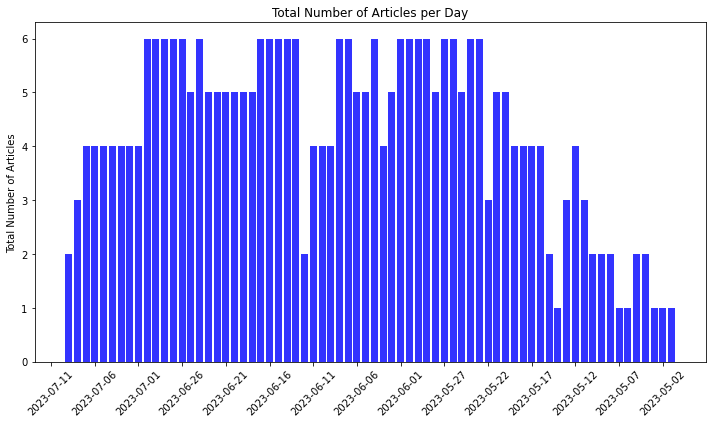

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming you have the DataFrame 'df' with the preprocessed data and the 'Newspaper' column

# Group the articles by day and count the total number of articles for each day
df_grouped = df.groupby(df['Date'].dt.date).size()

# Sort the DataFrame in reverse order of dates
df_grouped_sorted = df_grouped.sort_index(ascending=False)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart of the total number of articles per day
ax.bar(df_grouped_sorted.index, df_grouped_sorted.values, color='blue', alpha=0.8)

# Set the x-axis tick labels and rotation
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.invert_xaxis()
plt.xticks(rotation=45)

# Set the y-axis label and title
ax.set_ylabel('Total Number of Articles')
ax.set_title('Total Number of Articles per Day')

# Display the plot
plt.tight_layout()
plt.show()


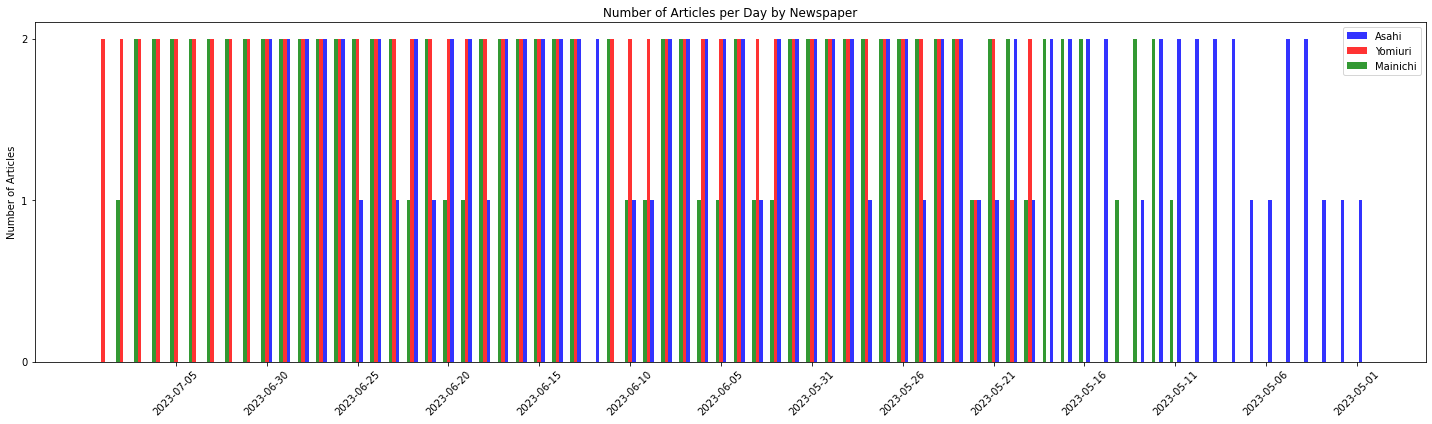

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the DataFrame 'df' with the preprocessed data and the 'Newspaper' column

# Group the articles by date and newspaper, and count the number of articles for each combination
df_grouped = df.groupby([df['Date'].dt.date, 'Newspaper']).size().reset_index(name='Count')

# Pivot the DataFrame to have dates as rows and newspapers as columns
df_pivot = df_grouped.pivot(index='Date', columns='Newspaper', values='Count').fillna(0)

# Get the unique dates
dates = df_pivot.index

# Get the number of newspapers
num_newspapers = df_pivot.shape[1]

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(dates))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the bars for each newspaper
ax.bar(r1, df_pivot['asahi'], color='blue', width=bar_width, alpha=0.8, label='Asahi')
ax.bar(r2, df_pivot['yomiuri'], color='red', width=bar_width, alpha=0.8, label='Yomiuri')
ax.bar(r3, df_pivot['mainichi'], color='green', width=bar_width, alpha=0.8, label='Mainichi')

# Set the x-axis tick labels and rotation
ax.set_xticks(r2[::5])  # Show tick labels every 5th position
ax.set_xticklabels(dates[::5], rotation=45)

# Invert the x-axis
ax.invert_xaxis()

# Set the y-axis as integers
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Set the y-axis label and title
ax.set_ylabel('Number of Articles')
ax.set_title('Number of Articles per Day by Newspaper')

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

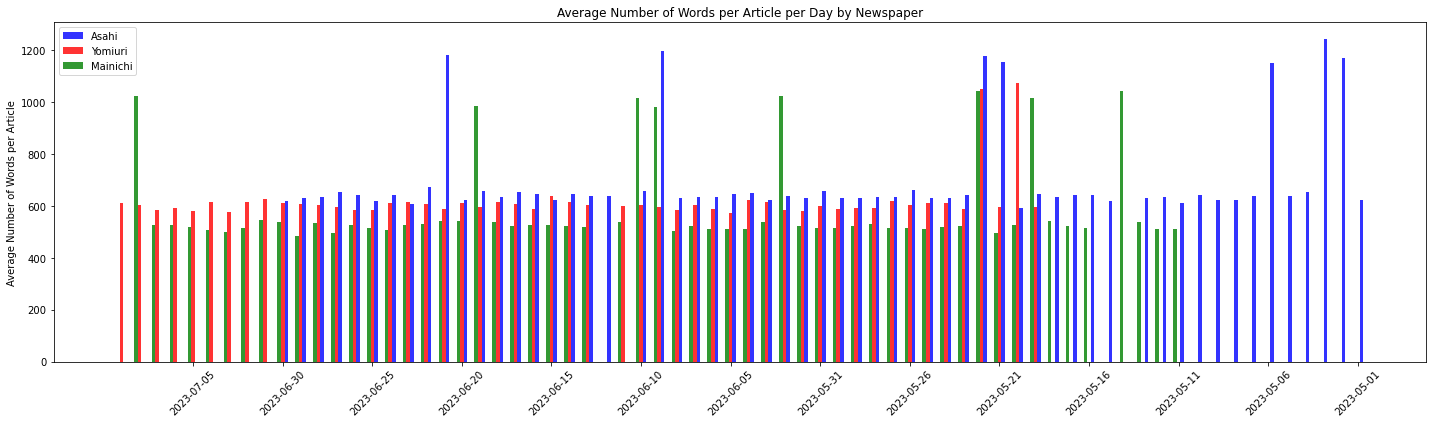

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the DataFrame 'df' with the preprocessed data and the 'Newspaper' column

# Group the articles by date, newspaper, and calculate the average number of words per article for each combination
df_grouped = df.groupby([df['Date'].dt.date, 'Newspaper'])['Word_Count'].mean().reset_index(name='AvgWords')

# Pivot the DataFrame to have dates as rows and newspapers as columns
df_pivot = df_grouped.pivot(index='Date', columns='Newspaper', values='AvgWords').fillna(0)

# Get the unique dates
dates = df_pivot.index

# Get the number of newspapers
num_newspapers = df_pivot.shape[1]

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(dates))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the bars for each newspaper
ax.bar(r1, df_pivot['asahi'], color='blue', width=bar_width, alpha=0.8, label='Asahi')
ax.bar(r2, df_pivot['yomiuri'], color='red', width=bar_width, alpha=0.8, label='Yomiuri')
ax.bar(r3, df_pivot['mainichi'], color='green', width=bar_width, alpha=0.8, label='Mainichi')

# Set the x-axis tick labels and rotation
ax.set_xticks(r2[::5])  # Show tick labels every 5th position
ax.set_xticklabels(dates[::5], rotation=45)

# Invert the x-axis
ax.invert_xaxis()

# Set the y-axis label and title
ax.set_ylabel('Average Number of Words per Article')
ax.set_title('Average Number of Words per Article per Day by Newspaper')

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


### 1.2 前処理
* Japanese stop word list from 'https://github.com/stopwords/japanese-stopwords/'

In [ ]:
import MeCab
import re

def preprocess_japanese_text(text):
    # Initialize MeCab tokenizer
    tokenizer = MeCab.Tagger("-Owakati")

    # Tokenization
    tokenized_text = tokenizer.parse(text).strip()

    # Clean and filter unwanted characters
    cleaned_text = clean_text(tokenized_text)

    # Remove stop words if necessary
    filtered_text = remove_stop_words(cleaned_text)

    return filtered_text

def clean_text(text):
    # Regular expression pattern to match common punctuation marks
    pattern = r'[、。？！…ー「」･･･（）◆]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

def remove_stop_words(text):
    with open('./data/sw.txt', 'r', encoding='utf-8') as file:
        stop_words = [line.strip() for line in file.readlines()]
    # Tokenize the text
    tokens = text.split()

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Rejoin the filtered tokens
    filtered_text = " ".join(filtered_tokens)

    return filtered_text

# Example usage
sample_text = "こんにちは！（私は）日本語の文章です。これは、◆テストです。"
preprocessed_text = preprocess_japanese_text(sample_text)
print(preprocessed_text)

df['Preprocessed_Content'] = df['Content'].apply(preprocess_japanese_text)

## 3 ソースコードとしての工夫点
### 3.1 Javascript elementをSeleniumで扱う方法
データ収集段階では、朝日新聞と毎日新聞の各社説のページが「前の記事」というボッタンがあって、Seleniumを使わなくてもBeautifulSoupで古い記事のURLを取得することができます。 
<br>
読売新聞の場合ではこういう「前の記事」ボッタンを持っていませんので、Scrapingのストラテジーとして、'https://www.yomiuri.co.jp/editorial/' から記事のURLを抽出することになりました。  

<img decoding="async" src='./assets/yomiuri.png' width="80%">

この社説のページでは、「さらに読み込む」ボッタンがありまして、最初にロードされるの記事は20点で、一回ボッタンを押すともっと10点を読み込みます。 
実際`find_element`メソッドを使って、HTMLのIDやCSS Selectorによってボッタンの選択は不可能です。

    driver.find_element(By.ID, 'ajax_more_button').click() # not working

ボッタンを扱いできるように、Javascript scriptを実行しなければなりません

    driver.execute_script("return arguments[0].click()", element) # works

c.f.) https://stackoverflow.com/questions/76643641/how-to-click-a-button-with-selenium-on-a-javascript-page/76650771#76650771


## 4 参考文献
* "Feature Engineering for Machine Learning, Alice Zheng & Amanda Casari, O’Reilly 978-1-491-95324-2."（日本語版『機械学習のための特徴量エンジニアリング』Alice Zheng、Amanda Casari著、オライリー・ジャパン、ISBN978-4-87311-868-0）

## 5 付録：ソースコード
* github